In [1]:
# Force synchronous CUDA errors for accurate tracebacks
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:
class BraTSSliceDataset(Dataset):
    def __init__(self, case_dirs, transform=None):
        """
        case_dirs: list of full patient-folder paths
        """
        self.transform = transform
        self.image_mask_pairs = []
        for full_path in case_dirs:
            flair_path = glob(os.path.join(full_path, "*flair.nii*"))[0]
            mask_path  = glob(os.path.join(full_path, "*seg.nii*"))[0]

            flair = nib.load(flair_path).get_fdata()
            mask  = nib.load(mask_path).get_fdata()

            for z in range(flair.shape[2]):
                img = flair[:, :, z]
                msk = mask[:, :, z]
                if msk.max() == 0:
                    continue
                self.image_mask_pairs.append((full_path, z))

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        case_dir, z = self.image_mask_pairs[idx]
        # reload only this slice:
        flair_path = glob(os.path.join(case_dir, "*flair.nii*"))[0]
        mask_path  = glob(os.path.join(case_dir, "*seg.nii*"))[0]

        img = nib.load(flair_path).get_fdata()[:, :, z]
        msk = nib.load(mask_path).get_fdata()[:, :, z]

        # to tensor
        img = torch.from_numpy(img[None, ...]).float() / 255.0
        msk = torch.from_numpy(msk.astype(np.int64)).long()
        msk[msk == 4] = 3  # remap 4→3

        return img, msk


In [3]:
from sklearn.model_selection import train_test_split

BASE_DIR = "/home/hiranmoy/Downloads/Sameer/Brats/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
all_cases = sorted([
    os.path.join(BASE_DIR, d)
    for d in os.listdir(BASE_DIR)
    if d.startswith("BraTS20")
])

# fixed 7 train / 3 val
train_cases = all_cases[:7]
val_cases   = all_cases[7:10]

print(f"Total cases: {len(all_cases)} → Train: {len(train_cases)}, Val: {len(val_cases)}")

train_ds = BraTSSliceDataset(train_cases)
val_ds   = BraTSSliceDataset(val_cases)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=4)


Total cases: 369 → Train: 7, Val: 3


In [4]:
class SegNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=4):
        super().__init__()
        def enc_blk(c_in, c_out):
            return nn.Sequential(
                nn.Conv2d(c_in, c_out, 3, padding=1),
                nn.BatchNorm2d(c_out), nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, 3, padding=1),
                nn.BatchNorm2d(c_out), nn.ReLU(inplace=True)
            )
        def dec_blk(c_in, c_out):
            return nn.Sequential(
                nn.Conv2d(c_in, c_out, 3, padding=1),
                nn.BatchNorm2d(c_out), nn.ReLU(inplace=True),
                nn.Conv2d(c_out, c_out, 3, padding=1),
                nn.BatchNorm2d(c_out), nn.ReLU(inplace=True)
            )

        self.enc1 = enc_blk(in_channels, 64)
        self.enc2 = enc_blk(64, 128)
        self.enc3 = enc_blk(128, 256)
        self.pool   = nn.MaxPool2d(2, 2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.dec3 = dec_blk(256, 128)
        self.dec2 = dec_blk(128,  64)
        self.dec1 = dec_blk( 64,  4)  # num_classes

    def forward(self, x):
        x1 = self.enc1(x)
        x1p, i1 = self.pool(x1)
        x2 = self.enc2(x1p)
        x2p, i2 = self.pool(x2)
        x3 = self.enc3(x2p)
        x3p, i3 = self.pool(x3)

        u3 = self.unpool(x3p, i3, output_size=x3.size())
        d3 = self.dec3(u3)
        u2 = self.unpool(d3, i2, output_size=x2.size())
        d2 = self.dec2(u2)
        u1 = self.unpool(d2, i1, output_size=x1.size())
        d1 = self.dec1(u1)

        return d1


In [5]:
model     = SegNet(in_channels=1, num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [6]:
# If CUDA error comes up
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


In [7]:
def train_one_epoch(model, loader, opt, crit):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, desc="Train"):
        imgs, masks = imgs.to(device), masks.to(device)
        opt.zero_grad()
        logits = model(imgs)
        loss = crit(logits, masks)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, crit):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Val"):
            imgs, masks = imgs.to(device), masks.to(device)
            logits = model(imgs)
            loss = crit(logits, masks)
            total_loss += loss.item()
    return total_loss / len(loader)


In [8]:
num_epochs    = 10
best_val_loss = float("inf")

for ep in range(1, num_epochs+1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    vl_loss = validate(model, val_loader,   criterion)
    print(f"Epoch {ep}/{num_epochs} → Train Loss: {tr_loss:.4f}, Val Loss: {vl_loss:.4f}")
    if vl_loss < best_val_loss:
        best_val_loss = vl_loss
        torch.save(model.state_dict(), "best_segnet.pth")
        print("  🏆 Saved best model")


Val: 100%|██████████████████████████████████████| 24/24 [00:03<00:00,  6.46it/s]


Epoch 1/10 → Train Loss: 1.3188, Val Loss: 1.2328
  🏆 Saved best model


Val: 100%|██████████████████████████████████████| 24/24 [00:03<00:00,  6.66it/s]


Epoch 2/10 → Train Loss: 1.1602, Val Loss: 1.1163
  🏆 Saved best model


Val: 100%|██████████████████████████████████████| 24/24 [00:03<00:00,  6.52it/s]


Epoch 3/10 → Train Loss: 1.1241, Val Loss: 1.0996
  🏆 Saved best model


Val: 100%|██████████████████████████████████████| 24/24 [00:03<00:00,  6.61it/s]


Epoch 4/10 → Train Loss: 1.0904, Val Loss: 1.0802
  🏆 Saved best model


Val: 100%|██████████████████████████████████████| 24/24 [00:03<00:00,  6.66it/s]


Epoch 5/10 → Train Loss: 1.0852, Val Loss: 1.1186


Val: 100%|██████████████████████████████████████| 24/24 [00:03<00:00,  6.57it/s]


Epoch 6/10 → Train Loss: 1.0861, Val Loss: 1.0769
  🏆 Saved best model


Val: 100%|██████████████████████████████████████| 24/24 [00:03<00:00,  6.61it/s]


Epoch 7/10 → Train Loss: 1.0640, Val Loss: 1.0584
  🏆 Saved best model


Val: 100%|██████████████████████████████████████| 24/24 [00:03<00:00,  6.64it/s]


Epoch 8/10 → Train Loss: 1.0541, Val Loss: 1.0484
  🏆 Saved best model


Val: 100%|██████████████████████████████████████| 24/24 [00:03<00:00,  6.60it/s]


Epoch 9/10 → Train Loss: 1.0467, Val Loss: 1.0478
  🏆 Saved best model


Val: 100%|██████████████████████████████████████| 24/24 [00:03<00:00,  6.60it/s]

Epoch 10/10 → Train Loss: 1.0423, Val Loss: 1.0564


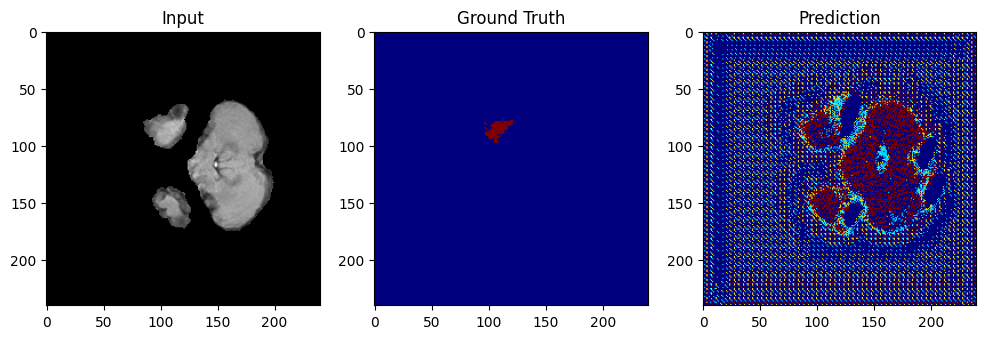

In [9]:
def visualize(model, dataset, idx=0):
    model.eval()
    img, gt = dataset[idx]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred = pred.argmax(dim=1).squeeze().cpu().numpy()

    fig, axes = plt.subplots(1,3, figsize=(12,4))
    axes[0].imshow(img.squeeze(), cmap="gray"); axes[0].set_title("Input")
    axes[1].imshow(gt, cmap="jet");          axes[1].set_title("Ground Truth")
    axes[2].imshow(pred, cmap="jet");        axes[2].set_title("Prediction")
    plt.show()

# Example
visualize(model, val_ds, idx=5)
